<a href="https://colab.research.google.com/github/PavelNovikov888/Anomaly_Detection/blob/master/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%94%D0%B5%D1%82%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install undetected-chromedriver --quiet
!pip install selenium --quiet

# ПОСТАНОВКА ЗАДАЧИ

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.
* Произведён парсинг данных о датах проведения передачи «Что? Где? Когда?»
* Построена модель, предсказывающая значение временного ряда продаж. Показано, что нет положительного misprediction.
* Построен boxplot, указано, что нет аномалии роста продаж после передачи.
* Сделана попытка кластеризации точек продаж (по всем трём вендорам).

Нужны даты проведения передач. Откуда их взять?
Стоит начать с статистических методов.
А если попробовать как-то предсказать продажи?
Давайте попробуем кластеризовать!

In [115]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA

#метод для перебора параметров ARIMA
!pip install pmdarima --quiet
import pmdarima as pm

import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

#используем версию webdriver, которая необнаруживается анти-ботами
import undetected_chromedriver as webdriver
import time

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Start the Chrome driver
driver = webdriver.Chrome(options=options)

In [3]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1i77jXo_zDgkFr0knVkRjRLO8_MGptfBL"})
# https://drive.google.com/file/d/1i77jXo_zDgkFr0knVkRjRLO8_MGptfBL/view?usp=sharing
download.GetContentFile("tea_demand.zip")

In [4]:
# загрузим данные для анализа отказа системы регулирования температуры в помещении
df = pd.read_csv("tea_demand.zip", sep= '\t')
# ipton — 29; ahmad — 178; may — 5152
df['brand_id'].value_counts()

5152    153
178     153
29      153
Name: brand_id, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand_id        459 non-null    int64 
 1   date            459 non-null    object
 2   receipts_count  459 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.9+ KB


In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [8]:
df.nunique()

brand_id            3
date              153
receipts_count    313
dtype: int64

In [9]:
print(df.describe(datetime_is_numeric=True))

          brand_id                           date  receipts_count
count   459.000000                            459      459.000000
mean   1786.333333  2016-09-15 00:00:00.000000256      362.209150
min      29.000000            2016-07-01 00:00:00       73.000000
25%      29.000000            2016-08-08 00:00:00      186.500000
50%     178.000000            2016-09-15 00:00:00      339.000000
75%    5152.000000            2016-10-23 00:00:00      529.000000
max    5152.000000            2016-11-30 00:00:00     1301.000000
std    2383.260539                            NaN      220.350485


# Парсинг

In [10]:
# Navigate to a website
driver.get('https://www.toramp.com/')
#ожидаем полной загрузки сайта
driver.set_page_load_timeout(3)

#выведем на экран название теста
title = driver.title
print(title, end ="\n\n")

Даты выхода сериалов и аниме — Торамп



In [11]:
element = driver.find_element(By.XPATH, "/html/body/div/nav/div[1]/div[2]/div[1]/input")
element.send_keys("Что Где Когда")
time.sleep(5)
element.send_keys(Keys.ENTER)

search_title = driver.find_element(By.CLASS_NAME, 'search_results_on_enter_text').text
print(search_title, end ="\n\n")

Результаты поиска по 'Что Где Когда'



In [12]:
select = driver.find_element(By.XPATH, '/html/body/div/main/div/section/ul/li[1]/div/div/div[1]/div[1]/a')
select.send_keys(Keys.ENTER)
time.sleep(3)
test = driver.find_element(By.TAG_NAME, 'h1').text
print(test, end ="\n\n")

Что? Где? Когда? (1975 — ...)
сериал



In [13]:
all_options = driver.find_elements(By.TAG_NAME, "time")
dates = []
for option in all_options:
  dates.append(option.get_attribute("datetime"))

data_tv_air = pd.DataFrame(dates, columns = ['date'])
data_tv_air['date'] = pd.to_datetime(data_tv_air['date'])
data_tv_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    589 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.7 KB


In [14]:
data_tv_air

,date
0,2023-03-19
1,2023-03-26
2,2023-04-02
3,2023-04-09
4,2023-04-16
...,...
584,1976-04-24
585,1975-09-04
586,2002-03-16
587,2015-11-29


In [15]:
mask1 = df.date.min()
mask2 = df.date.max()

In [16]:
data_tv_filter = data_tv_air[(data_tv_air['date'] >= mask1)&(data_tv_air['date'] <= mask2)].reset_index(drop=True)

In [17]:
data_tv_filter


,date
0,2016-09-25
1,2016-10-02
2,2016-10-09
3,2016-10-16
4,2016-10-23
5,2016-11-21
6,2016-11-28


In [18]:
date_start = data_tv_filter['date'].min()
date_stop = data_tv_filter['date'].min()

# СТАТИСТИЧЕСКИЕ ТЕСТЫ

In [19]:
df_pivot = pd.pivot_table(df,
               index=["date"],
               values=["receipts_count"],
               columns=["brand_id"],
               aggfunc = ('sum'),
              margins = True)
df_pivot.columns = ['Lipton', 'Ahmad', 'May', 'All']
df_pivot.drop(labels = ['All'], axis =0, inplace = True)

In [20]:
df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot.index

DatetimeIndex(['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04',
               '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08',
               '2016-07-09', '2016-07-10',
               ...
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=153, freq=None)

In [21]:
# разделим выборку на продажи до начала рекламной компании и после
df_before = df_pivot[df_pivot.index < date_start]
df_after = df_pivot[df_pivot.index >= date_start]

In [22]:
df_before.shape

(86, 4)

In [23]:
df_after.shape

(67, 4)

In [24]:
df_before.head()


,Lipton,Ahmad,May,All
date,,,,
2016-07-01,622,234,98,954
2016-07-02,580,185,87,852
2016-07-03,687,190,105,982
2016-07-04,550,196,141,887
2016-07-05,529,336,137,1002


In [25]:
import scipy.stats as stats

def test_shapiro(data, alpha = 0.05):
  # проводим тест Шапиро — Уилка
  _, p = stats.shapiro(data)
  print('p-value = %.3f' % (p))
  # интерпретируем результат
  if p <= alpha:
      print('Распределение не нормальное')
  else:
      print('Распределение нормальное')

## Тест на равенство средних

Будем исходить из предположения, что реклама чая "Ахмад" действует на покупателя всё время после начала рекламной компании.  
Поэтому разделим выборку на 2 части до старта рекламы и после старта рекламы.   
Продажи даны в натуральных величинах(коробках?), будем считать что они стоят одинаково.

In [26]:
test_shapiro(df_before['Ahmad'])

p-value = 0.000
Распределение не нормальное


In [27]:
test_shapiro(df_after['Ahmad'])

p-value = 0.000
Распределение не нормальное


Вывод: Т.к. данные распределены не нормально, а выборки зависимы, то для определения наличия различий этих выборок нам подойдёт Критерий Уилкинсона.

Т.к. нас интересует выше ли стали продажи, используем левосторонюю ('less')альтернативную гипотезу.

Сформулируем гипотезы в математическом виде:

**Нулевая гипотеза:** среднее количество проданных коробок чая 'Ahmad' до и после рекламной компании одинаковы, влияния рекламы на распределение нет.  
**Альтернативная гипотеза:** среднее количество проданных коробок чая 'Ahmad' до и после рекламной компании различны, влияние рекламы на распределение есть, продажи стали выше.

In [28]:
length = df_after['Ahmad'].shape[0]
column = df_after.columns.get_loc('Ahmad')
ahmad_before = df_before.iloc[:length, column]
print(df_after['Ahmad'].shape)
print(ahmad_before.shape)


(67,)
(67,)


In [29]:
from pandas.core.indexers import length_of_indexer
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05

# создаем выборки
length = df_after['Ahmad'].shape[0]
column = df_after.columns.get_loc('Ahmad')
ahmad_before = df_before.iloc[:length, column]

# проводим тест
_, p = stats.wilcoxon(ahmad_before, df_after['Ahmad'], alternative = 'less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# p-value = 0.000
# p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.
# Вывод: время получения ответа через чат-бота меньше, чем через звонок оператору.

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Продажи чая Ахмад до рекламной компании меньше, чем после неё.

## Тест на равенство средних

Помимо теста на средние продажи зададимся вопросом изменилась ли доля продаж чая "Ахмад" по сравнению с конкурентами. Стала ли она выше?



In [30]:
# подготовим данные
df_before.loc[:, 'Ahmad_part'] = df_before.loc[:, 'Ahmad']/df_before.loc[:, 'All']
df_after.loc[:, 'Ahmad_part'] = df_after.loc[:, 'Ahmad']/df_after.loc[:, 'All']

<ipython-input-30-da4f3959c808>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before.loc[:, 'Ahmad_part'] = df_before.loc[:, 'Ahmad']/df_before.loc[:, 'All']
<ipython-input-30-da4f3959c808>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after.loc[:, 'Ahmad_part'] = df_after.loc[:, 'Ahmad']/df_after.loc[:, 'All']


In [31]:
df_before.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86 entries, 2016-07-01 to 2016-09-24
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Lipton      86 non-null     int64  
 1   Ahmad       86 non-null     int64  
 2   May         86 non-null     int64  
 3   All         86 non-null     int64  
 4   Ahmad_part  86 non-null     float64
dtypes: float64(1), int64(4)
memory usage: 4.0 KB


### Тест на нормальность

In [32]:
test_shapiro(df_before['Ahmad_part'])

p-value = 0.002
Распределение не нормальное


In [33]:
test_shapiro(df_after['Ahmad_part'])

p-value = 0.024
Распределение не нормальное


Вывод: Т.к. данные распределены не нормально, а выборки зависимы, то для определения наличия различий этих выборок нам подойдёт Критерий Уилкинсона.

Т.к. нас интересует выше ли стала доля продаж, используем левосторонюю ('less')альтернативную гипотезу.

Сформулируем гипотезы в математическом виде:

Нулевая гипотеза:  доля проданных коробок чая 'Ahmad' по српавнению с конкурентами до и после рекламной компании одинаковы, влияния рекламы на распределение нет.
Альтернативная гипотеза: доля проданных коробок чая 'Ahmad' до и после рекламной компании различны, влияние рекламы на распределение есть, доля стала выше.

In [34]:
length = df_after['Ahmad'].shape[0]
column = df_after.columns.get_loc('Ahmad')
ahmad_before = df_before.iloc[:length, column]
print(df_after['Ahmad'].shape)
print(ahmad_before.shape)

(67,)
(67,)


In [35]:
# создаем выборки
length = df_after['Ahmad_part'].shape[0]
column = df_after.columns.get_loc('Ahmad_part')
ahmad_before = df_before.iloc[:length, column]

# проводим тест
_, p = stats.wilcoxon(ahmad_before, df_after['Ahmad_part'], alternative = 'less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# p-value = 0.000
# p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.
# Вывод: время получения ответа через чат-бота меньше, чем через звонок оператору.

p-value = 0.289
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: Статистически значимого изменения доли продаж не выявлено.

Дальнейшее исследование необходимо,чтобы выявить кратковременные всплески продаж, которые мы будетектировать как аномалии и сопоставить эти всплески и даты выходы рекламы. Чем ближе аномалия к этой дате тем вероятнее её влияние на продажи.

Начнем с поиска аномалий с помощью формулы Тьюки

In [36]:
# подготовим данные
df_pivot.loc[:,'Ahmad_part'] = df_pivot.loc[:,'Ahmad']/df_pivot.loc[:,'All']

In [37]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [38]:
# начнем с абсолютных продаж
outliers_abs, cleaned = outliers_iqr(df_pivot, 'Ahmad')
print('Абсолютные продажи')
print(f'Число выбросов по методу Тьюки: {outliers_abs.shape[0]}')
print(outliers_abs)
print(f'Результирующее число записей: {cleaned.shape[0]}')
def nearest(outliers, adv_list, treshold = 3):
  list_near = []
  for i in range(0,len(adv_list)):
    near_day = min(outliers.index, key=lambda x: x-adv_list.iloc[i,0])
    count_day = (near_day - adv_list.iloc[i,0])/np.timedelta64 ( 1 , 'D')
    if (count_day <= treshold) and (count_day >= 0):
      list_near.append((outliers.index, near_day, count_day))
  return list_near


print(nearest(outliers_abs, data_tv_filter))

# теперь доля продаж
outliers_rel, cleaned = outliers_iqr(df_pivot, 'Ahmad_part')
print('\nДоля продаж')
print(f'Число выбросов по методу Тьюки: {outliers_rel.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Абсолютные продажи
Число выбросов по методу Тьюки: 3
            Lipton  Ahmad  May   All  Ahmad_part
date                                            
2016-10-31     496    677  255  1428    0.474090
2016-11-09     372    708  357  1437    0.492693
2016-11-10     381    712  349  1442    0.493759
Результирующее число записей: 150
[]

Доля продаж
Число выбросов по методу Тьюки: 0
Результирующее число записей: 153


Выводы перекликаются с предыдущими.

# Временной ряд
Основная идея состоит в сравнении фактических и прогнозных показателей.
Если прогноз дает значения меньше фактических, значит реклама действует и повышает показатели продаж.
Если наоборот, прогноз дает значения выше тех, что происходят на самом деле, значит существуют ложноположительные прогнозы(присутствует положительный misprediction).
Мы сравним с помощью метрики RMSE


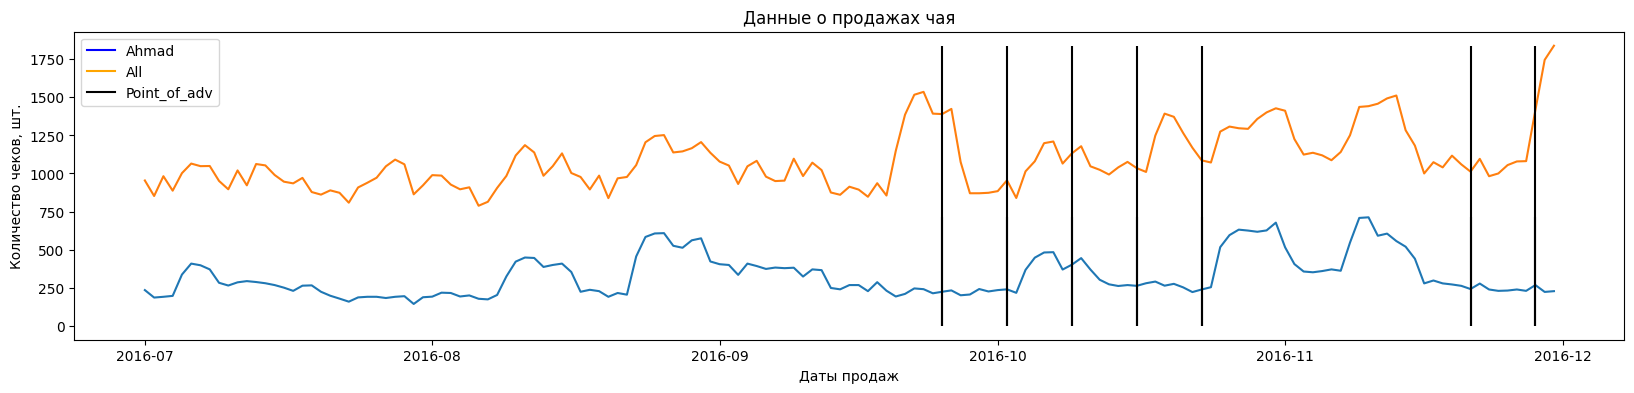

In [39]:
#создадим датафрейм, в который мы будем накапливать временные ряды по странам для анализа корреляций между ними
df_corr = pd.DataFrame()
#зададим размер графика
plt.rcParams['figure.figsize'] = [20, 4]
#создадим объект фигуры
fig = plt.figure()
ax = plt.subplot(111)
# создадим список брендов и общий
list_brand = df_pivot[['Ahmad', 'All']]
# в цикле нанесем на график продажи в по брендам
for brand in list_brand:
  # сделаем срез данных по бренду
  df_for_plot = df_pivot[brand]
  # проводим нормализацию данных
  # df_sales = df_for_plot/df_for_plot.sum()*100
  df_sales = df_for_plot
  # производим декомпозицию временного ряда, устраним недельный тренд
  decomposition = seasonal_decompose(df_sales)
  # удаляем пропуски
  trend7 = decomposition.observed.dropna()
  # добавим данные в датафрейм для последующего анализа корреляций
  df_corr[brand] = trend7
  # добавим график на фигуру
  # fig, ax = plt.subplots()
  blue_line = mlines.Line2D([], [], color='blue', label='Ahmad')
  orange_line = mlines.Line2D([], [], color='orange', label='All')
  black_line = mlines.Line2D([], [], color='black', label='Point_of_adv')
  # Заголовок таблицы
  plt.title("Данные о продажах чая")
  # Подписи осей
  plt.xlabel("Даты продаж")
  plt.ylabel("Количество чеков, шт.")
  plt.plot(trend7)
  ax.legend(handles=[blue_line, orange_line, black_line], loc ='upper left')
  ax.vlines(data_tv_filter['date'], 0, df_sales.max(),colors='black')



## Делаем предсказание с помощью Arima

## Подготовка данных

В качестве тренировочного датасета будем использовать данные о продажах до начала выхода конкретной передачи включительно.
Тестовая часть будет включать 7 дней после выхода конктреной передачи.  

Сделаем baseline за неделю до начала рекламы и протестируем на данных за последнюю перед началом рекламной компании неделю.  
Baseline: train: 2016-01-07 test:

In [40]:
df_pivot

,Lipton,Ahmad,May,All,Ahmad_part
date,,,,,
2016-07-01,622,234,98,954,0.245283
2016-07-02,580,185,87,852,0.217136
2016-07-03,687,190,105,982,0.193483
2016-07-04,550,196,141,887,0.220970
2016-07-05,529,336,137,1002,0.335329
...,...,...,...,...,...
2016-11-26,518,238,323,1079,0.220575
2016-11-27,493,229,359,1081,0.211841
2016-11-28,856,267,294,1417,0.188426


## Проверка временного ряда на стацинарность

In [49]:
def stat_test(df):
    """Функция для определения стационарности временного ряда с помощью теста Дики-Фуллера

    Args:df (DataFrame,array): данные временного ряда
    """
    test = sm.tsa.adfuller(df) # определение статистик теста Дики-Фуллера
    print ('adf: ', test[0] ) #Test statistic
    print ('p-value: ', test[1]) #MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)
    print('Critical values: ', test[4]) #Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
    if test[0]> test[4]['5%']:
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [92]:
y_train = df_pivot.loc[:'2016-09-24','Ahmad']
y_test = df_pivot.loc['2016-09-25':,'Ahmad']
print(f'Базовое решение: {stat_test(y_train)}')

adf:  -2.961371259280991
p-value:  0.03866271829249545
Critical values:  {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
единичных корней нет, ряд стационарен
Базовое решение: None


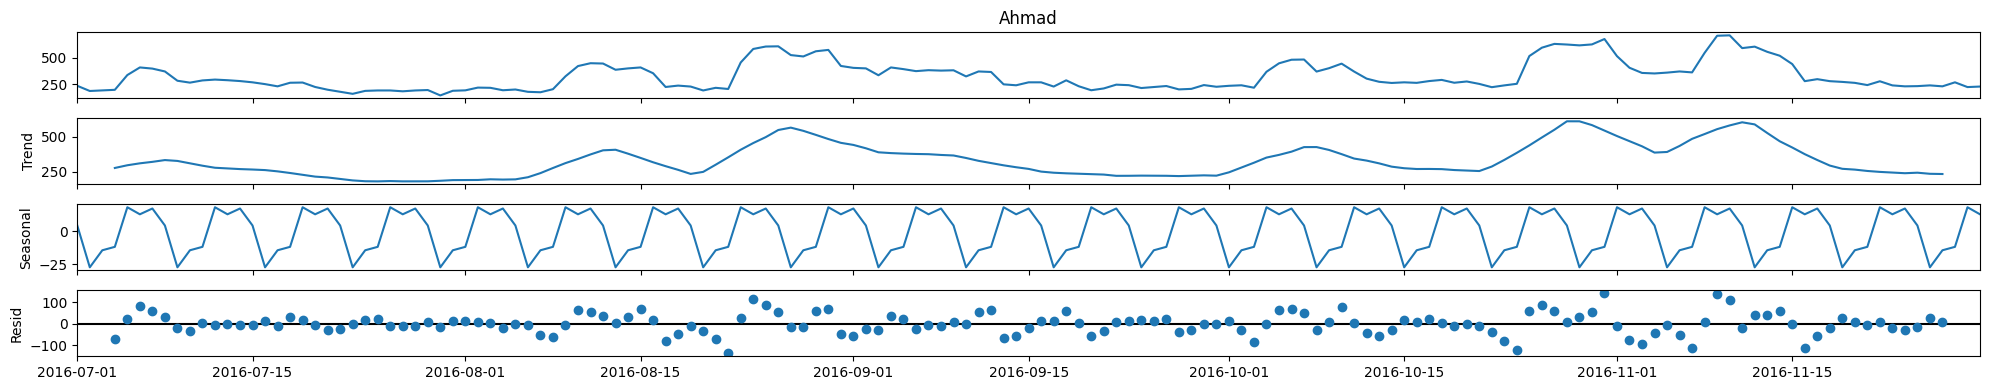

In [100]:

#импортируем библиотеку
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда
decomposition = seasonal_decompose(df_pivot['Ahmad'])
fig = decomposition.plot()
plt.show()

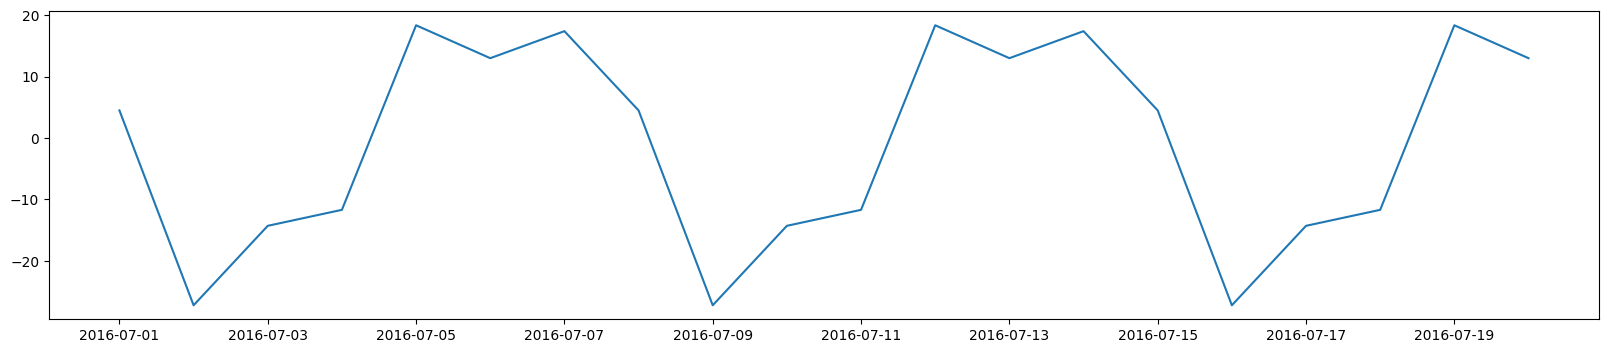

In [108]:
#удаляем пропуски
trend7 = decomposition.seasonal.dropna()
# добавим график на фигуру
plt.plot(trend7[:20])

Присутсвует недельный тренд

In [73]:
y_train1 = df_pivot.loc['2016-07-01':'2016-09-17','Ahmad']
y_test1 = df_pivot.loc['2016-09-18':'2016-09-23','Ahmad']
print(f'1 ряд: {stat_test(y_train1)}')

y_train2 = df_pivot.loc['2016-07-01':'2016-09-25','Ahmad']
y_test2 = df_pivot.loc['2016-09-26':'2016-10-01','Ahmad']
print(f'2 ряд: {stat_test(y_train2)}')

y_train3 = df_pivot.loc['2016-07-01':'2016-10-01','Ahmad']
y_test3 = df_pivot.loc['2016-10-02':'2016-10-07','Ahmad']
print(f'3 ряд: {stat_test(y_train3)}')

y_train4 = df_pivot.loc['2016-07-01':'2016-10-09','Ahmad']
y_test4 = df_pivot.loc['2016-10-10':'2016-10-15','Ahmad']
print(f'4 ряд: {stat_test(y_train4)}')

y_train5 = df_pivot.loc['2016-07-01':'2016-10-16','Ahmad']
y_test5 = df_pivot.loc['2016-10-17':'2016-10-22','Ahmad']
print(f'5 ряд: {stat_test(y_train5)}')

y_train6 = df_pivot.loc['2016-07-01':'2016-10-23','Ahmad']
y_test6 = df_pivot.loc['2016-10-24':'2016-10-29','Ahmad']
print(f'6 ряд: {stat_test(y_train6)}')

y_train7 = df_pivot.loc['2016-07-01':'2016-11-21','Ahmad']
y_test7 = df_pivot.loc['2016-11-22':'2016-11-27','Ahmad']
print(f'7 ряд: {stat_test(y_train7)}')

adf:  -2.925366374389596
p-value:  0.042476752910179744
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
единичных корней нет, ряд стационарен
1 ряд: None
adf:  -2.9935249577369887
p-value:  0.03550352832088059
Critical values:  {'1%': -3.5097356063504983, '5%': -2.8961947486260944, '10%': -2.5852576124567475}
единичных корней нет, ряд стационарен
2 ряд: None
adf:  -3.0468235227367293
p-value:  0.030747059707763133
Critical values:  {'1%': -3.50434289821397, '5%': -2.8938659630479413, '10%': -2.5840147047458037}
единичных корней нет, ряд стационарен
3 ряд: None
adf:  -3.2129505853430094
p-value:  0.019247180658585165
Critical values:  {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
единичных корней нет, ряд стационарен
4 ряд: None
adf:  -1.9131548385917987
p-value:  0.32589818987775787
Critical values:  {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}
есть единичные корни,

In [57]:
y_train5_1 = y_train5.diff().dropna()
y_train5_2 = y_train5_1.diff().dropna()
print(f'5 дифф. ряд: {stat_test(y_train5_2)}')
y_train6_1 = y_train6.diff().dropna()
y_train6_2 = y_train6_1.diff().dropna()
print(f'6 дифф. ряд: {stat_test(y_train6_2)}')
y_train7_1 = y_train7.diff().dropna()
y_train7_2 = y_train7_1.diff().dropna()
print(f'7 дифф. ряд: {stat_test(y_train7_2)}')

adf:  -6.806736350388913
p-value:  2.1671503335691358e-09
Critical values:  {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}
единичных корней нет, ряд стационарен
5 дифф. ряд: None
adf:  -6.974521618402201
p-value:  8.496083706611931e-10
Critical values:  {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}
единичных корней нет, ряд стационарен
6 дифф. ряд: None
adf:  -8.095359810324512
p-value:  1.3436279283918531e-12
Critical values:  {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
единичных корней нет, ряд стационарен
7 дифф. ряд: None


## Определим автокорреляцию и частичную корреляцию.

In [58]:
import statsmodels.graphics.tsaplots as sgt
def plot_acf_pacf(series, lags, alpha=0.05):
    """Функция для построения графиков автокорреляции и частичной корреляции(коррелограм)

    Args:
        series (DataFrame, array): стационарный временной ряд
        lags (_type_): количество предыдущих наблюдений для поиска схожести/зависимости
        alpha (float, optional): Доверительный интервал. Defaults to 0.05.
    """

    plt.rcParams["figure.figsize"] = 18, 5 #размеры графика
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0], lags=lags, alpha=alpha)#построение графика автокорреляции
    sgt.plot_pacf(series, ax=axes[1], lags=lags, method="ywm", alpha=alpha)#построение графика автокорреляции
    plt.show()

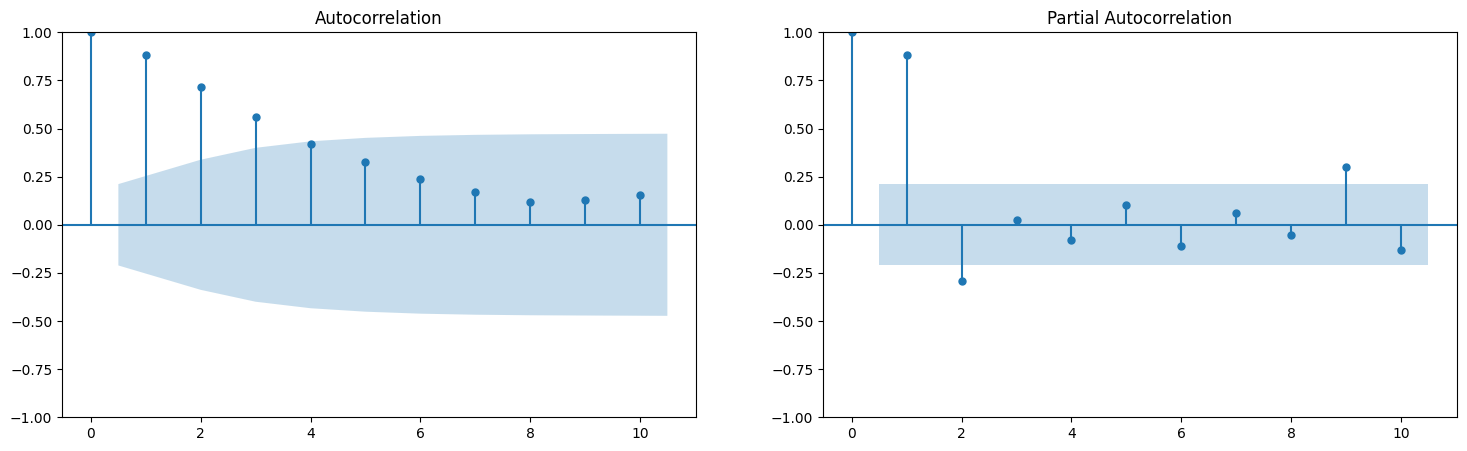

In [93]:
plot_acf_pacf(y_train, 10, alpha=0.05)

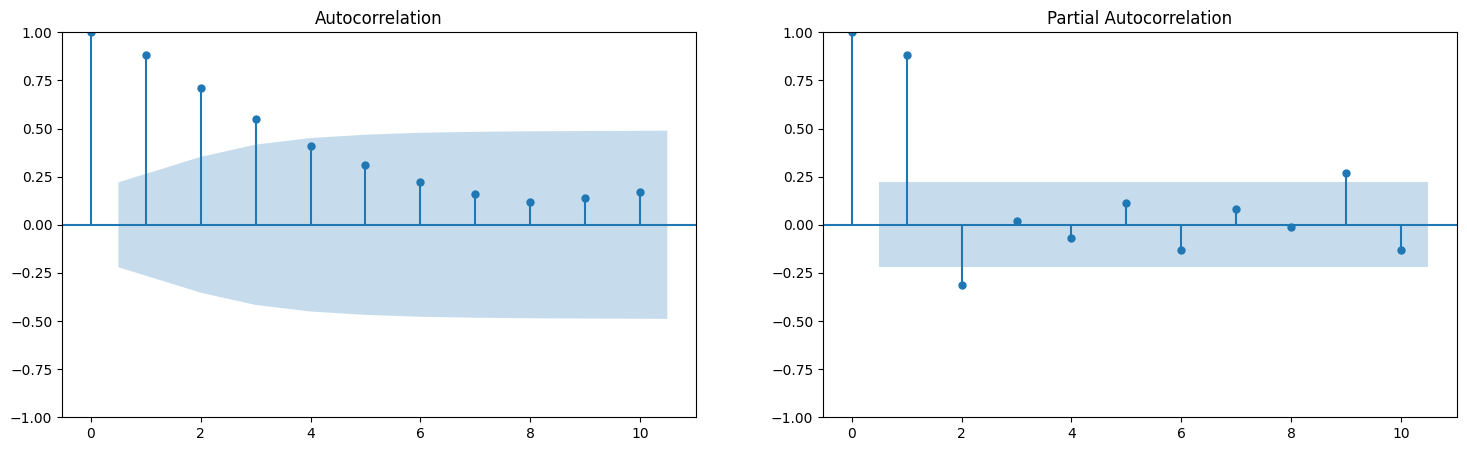

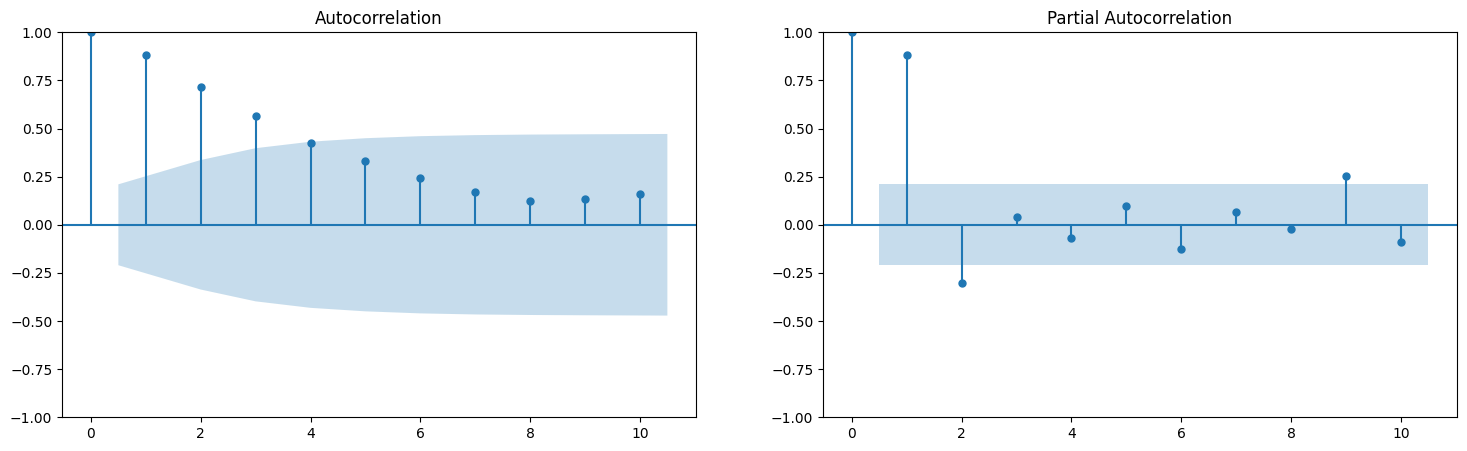

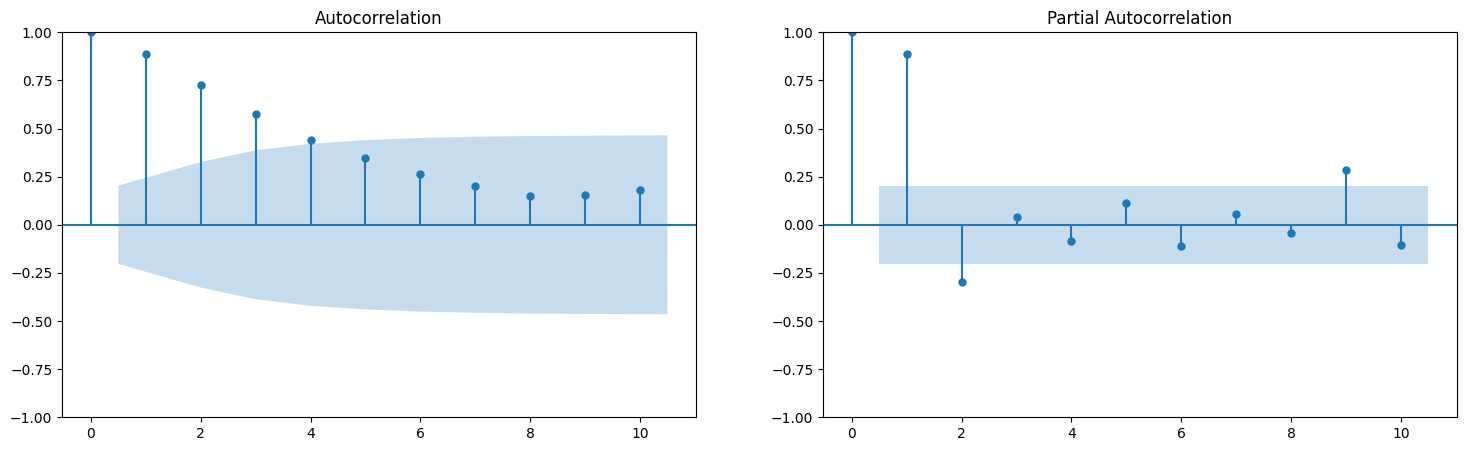

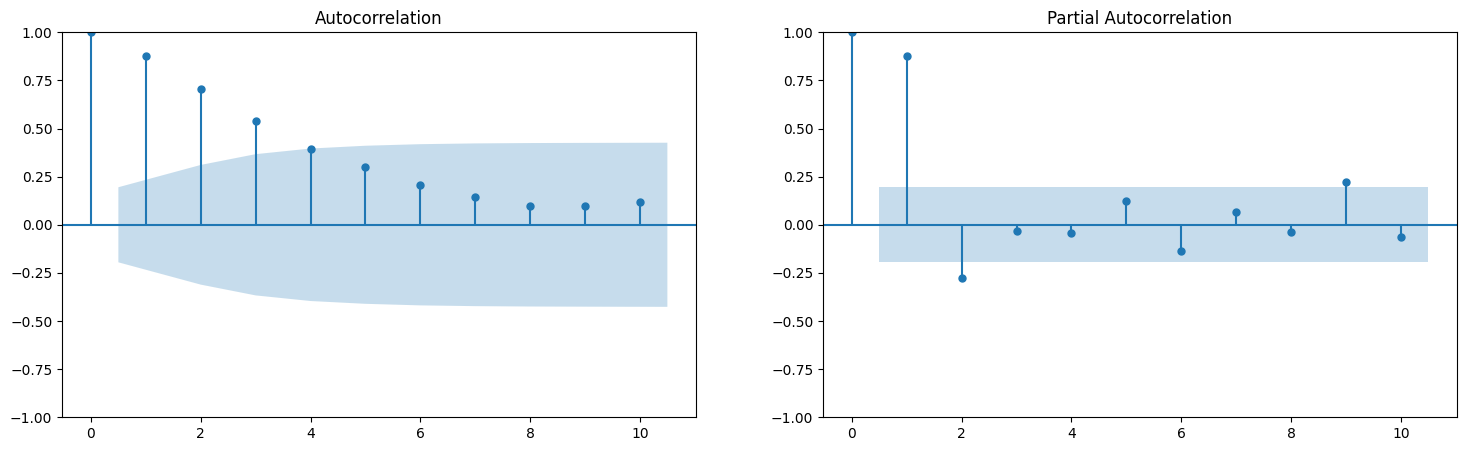

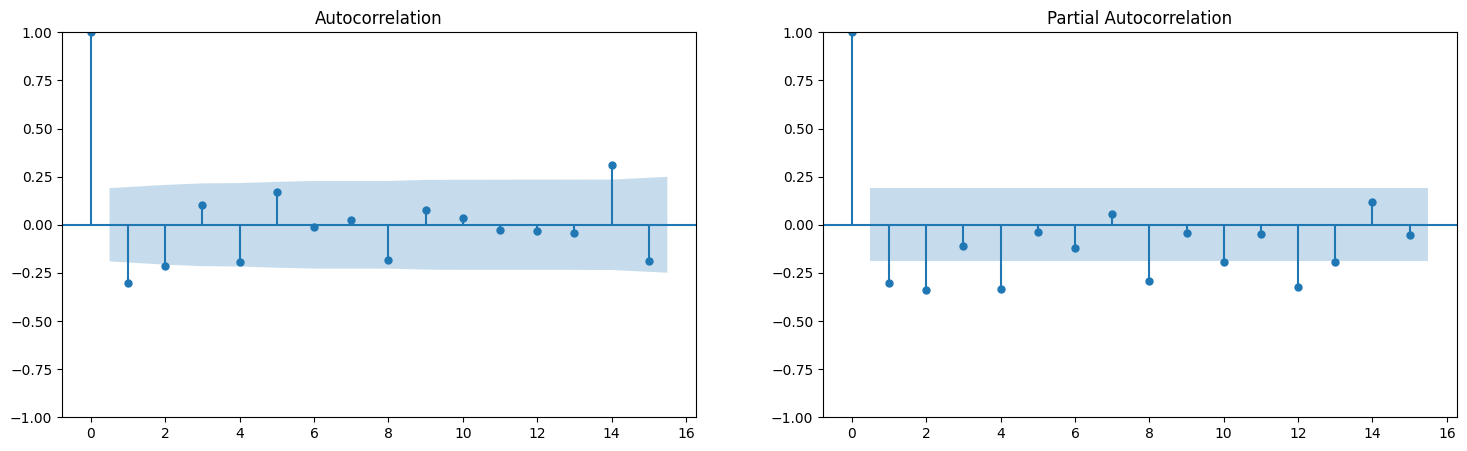

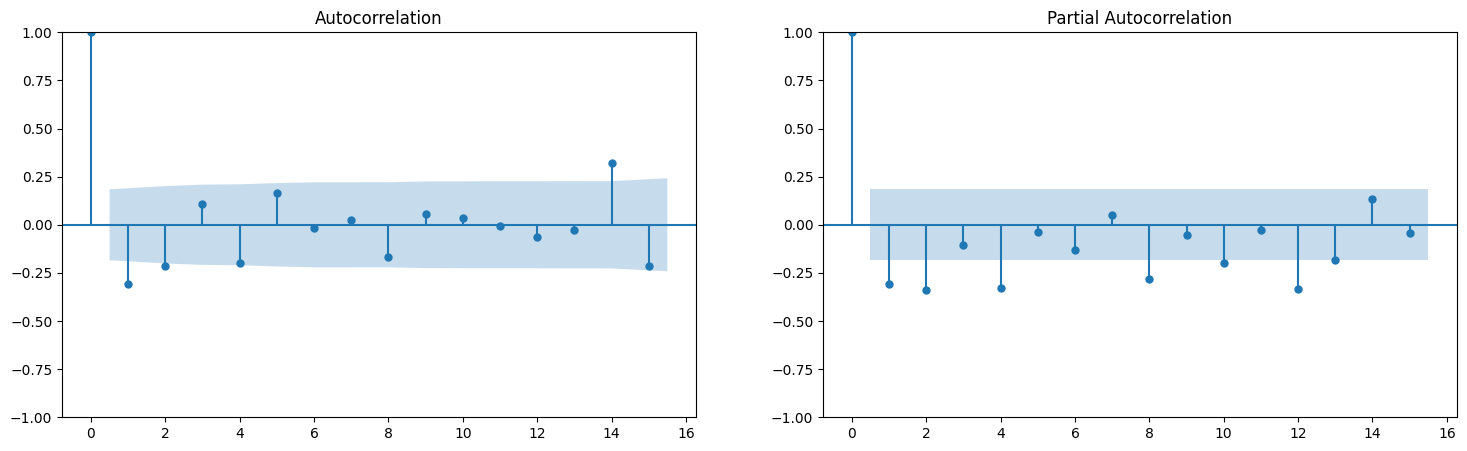

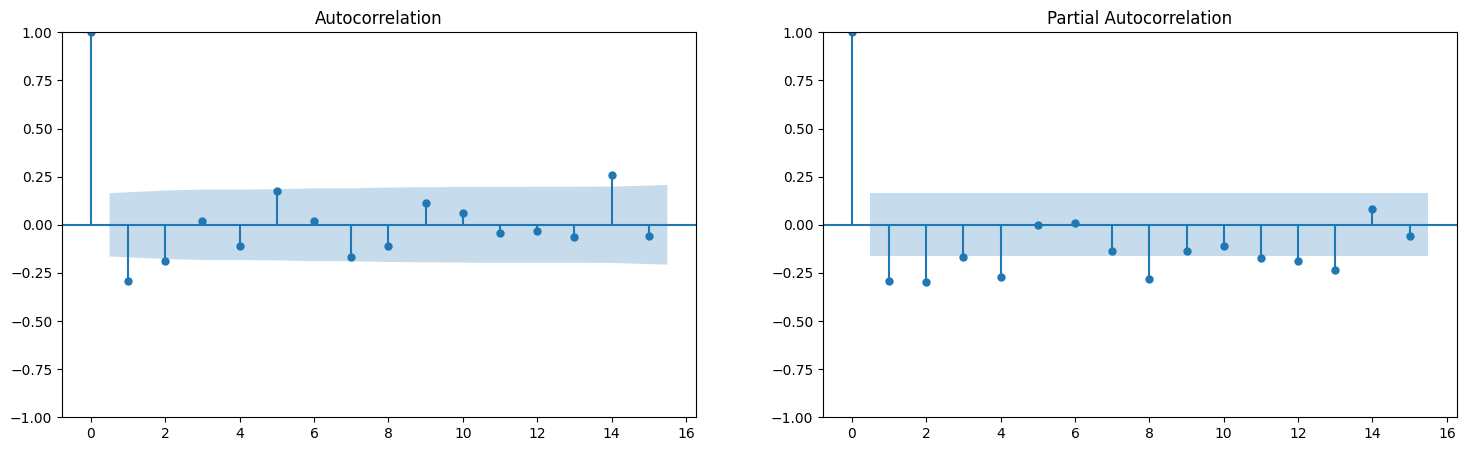

In [60]:
plot_acf_pacf(y_train1, 10, alpha=0.05)
plot_acf_pacf(y_train2, 10, alpha=0.05)
plot_acf_pacf(y_train3, 10, alpha=0.05)
plot_acf_pacf(y_train4, 10, alpha=0.05)
plot_acf_pacf(y_train5_2, 15, alpha=0.05)
plot_acf_pacf(y_train6_2, 15, alpha=0.05)
plot_acf_pacf(y_train7_2, 15, alpha=0.05)

Создадим модель ARIMA

In [120]:
smodel = pm.auto_arima(
    y_train,
    start_p=9,
    d=0,#порядок дифференцирования
    start_q=3,
    max_p=9,
    max_q=3,
    test="adf",
    start_P=2, D=None, start_Q=2, max_P=5, max_Q=5, max_order=20, m=7, seasonal=True,
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(6,0,3)(2,0,2)[7] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1064.616, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=936.599, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1238.727, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=935.101, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=936.803, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=935.411, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=929.229, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=930.875, Time=0.36 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=931.038, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=929.055, Time=0.59 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=924.769, Time=0.73 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=923.010, Time=0.69 sec
 ARIMA(2,0,0)(3,0,0)[7] intercept   : AIC=924.718, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 7)   Log Likelihood                -454.957
Date:                            Tue, 07 Nov 2023   AIC                            921.914
Time:                                    13:04:42   BIC                            936.641
Sample:                                07-01-2016   HQIC                           927.841
                                     - 09-24-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.3002     19.870      1.575      0.115      -7.644      70.245
ar.L1          0.8100      0.087      9.351      0.000       0.640       0.980
ma.L1          0.4062      0.126      3.216      0.001       0.159       0.654
ar.S.L7        0.0675      0.143      0.473      0.636      -0.212       0.347
ar.S.L14       0.3562      0.086      4.163      0.000       0.188       0.524
sigma2      2203.1216    280.795      7.846      0.000    1652.774    2753.470
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                81.80
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             1.14
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
train_size = len(y_train)
test_size = len(y_test)
model = ARIMA(y_train.values.reshape(-1), order=(2,0,2), seasonal_order= (2,0,0,7))
arima_predictions = model.fit().predict(start=train_size,end=train_size+test_size -1, dynamic=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
train_size1 = len(y_train1)
test_size = 6
model1 = ARIMA(y_train1.values.reshape(-1), order=(3,0,9))
arima_predictions1 = model1.fit().predict(start=train_size1,end=train_size1+test_size -1, dynamic=False)

train_size2 = len(y_train2)
model2 = ARIMA(y_train2.values.reshape(-1), order=(3,0,9))
arima_predictions2 = model2.fit().predict(start=train_size2,end=train_size2+test_size -1, dynamic=False)

train_size3 = len(y_train3)
model3 = ARIMA(y_train3.values.reshape(-1), order=(3,0,2))
arima_predictions3 = model3.fit().predict(start=train_size3,end=train_size3+test_size -1, dynamic=False)

train_size4 = len(y_train4)
model4 = ARIMA(y_train4.values.reshape(-1), order=(3,0,9))
arima_predictions4 = model4.fit().predict(start=train_size4,end=train_size4+test_size -1, dynamic=False)

train_size5 = len(y_train5)
model5 = ARIMA(y_train5.values.reshape(-1), order=(2,2,3))
arima_predictions5 = model5.fit().predict(start=train_size5,end=train_size5+test_size -1, dynamic=False)

train_size6 = len(y_train6)
model6 = ARIMA(y_train6.values.reshape(-1), order=(2,2,3))
arima_predictions6 = model6.fit().predict(start=train_size6,end=train_size6+test_size -1, dynamic=False)

train_size7 = len(y_train7)
model7 = ARIMA(y_train7.values.reshape(-1), order=(2,2,3))
arima_predictions7 = model7.fit().predict(start=train_size7,end=train_size7+test_size -1, dynamic=False)




# plt.plot(pd.concat([y_train1, y_test1], axis = 0), label = "Original")
# plt.plot(pd.Series(arima_predictions, index=y_test1.index) ,label = "Predictions")
# plt.legend(loc="upper right")
# plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


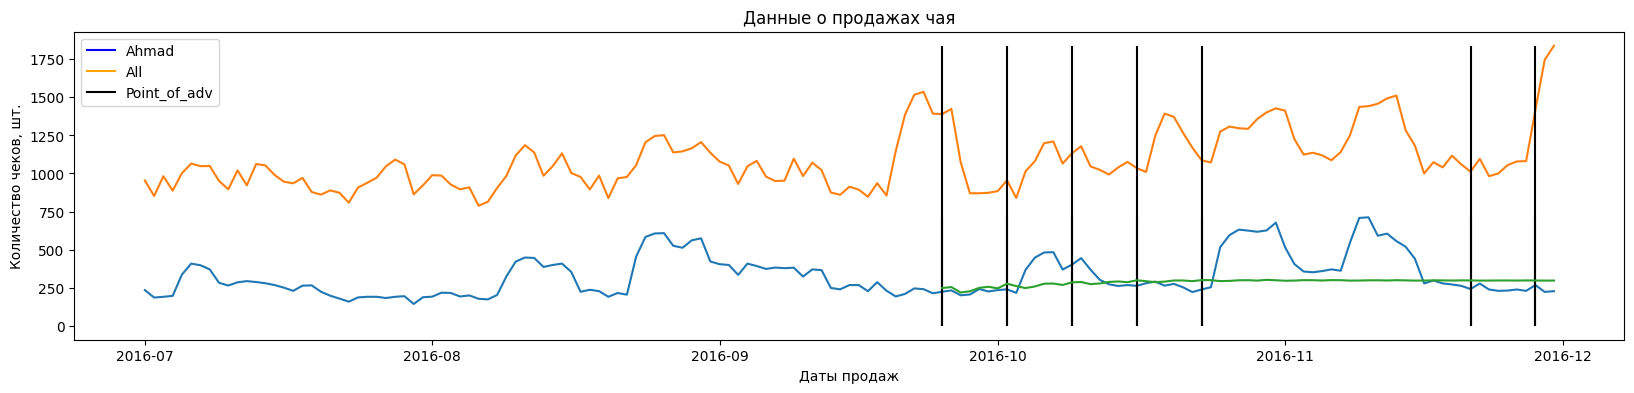

In [123]:
#создадим датафрейм, в который мы будем накапливать временные ряды по странам для анализа корреляций между ними
df_corr = pd.DataFrame()
#зададим размер графика
plt.rcParams['figure.figsize'] = [20, 4]
#создадим объект фигуры
fig = plt.figure()
ax = plt.subplot(111)
# создадим список брендов и общий
list_brand = df_pivot[['Ahmad', 'All']]
# в цикле нанесем на график продажи в по брендам
for brand in list_brand:
  # сделаем срез данных по бренду
  df_for_plot = df_pivot[brand]
  # проводим нормализацию данных
  # df_sales = df_for_plot/df_for_plot.sum()*100
  df_sales = df_for_plot
  # производим декомпозицию временного ряда, устраним недельный тренд
  decomposition = seasonal_decompose(df_sales)
  # удаляем пропуски
  trend7 = decomposition.observed.dropna()
  # добавим данные в датафрейм для последующего анализа корреляций
  df_corr[brand] = trend7
  # добавим график на фигуру
  # fig, ax = plt.subplots()
  blue_line = mlines.Line2D([], [], color='blue', label='Ahmad')
  orange_line = mlines.Line2D([], [], color='orange', label='All')
  black_line = mlines.Line2D([], [], color='black', label='Point_of_adv')
  # Заголовок таблицы
  plt.title("Данные о продажах чая")
  # Подписи осей
  plt.xlabel("Даты продаж")
  plt.ylabel("Количество чеков, шт.")
  plt.plot(trend7)
  ax.legend(handles=[blue_line, orange_line, black_line], loc ='upper left')
  ax.vlines(data_tv_filter['date'], 0, df_sales.max(),colors='black')
plt.plot(pd.Series(arima_predictions, index=y_test.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions1, index=y_test1.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions2, index=y_test2.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions3, index=y_test3.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions4, index=y_test4.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions5, index=y_test5.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions6, index=y_test6.index) ,label = "Predictions")
# plt.plot(pd.Series(arima_predictions7, index=y_test7.index) ,label = "Predictions")


In [ ]:
#создадим датафрейм, в который мы будем накапливать временные ряды по странам для анализа корреляций между ними
df_corr = pd.DataFrame()
#зададим размер графика
plt.rcParams['figure.figsize'] = [15, 4]
#создадим объект фигуры
fig = plt.figure()
ax = plt.subplot(111)
# создадим список брендов и общий
list_brand = df_pivot.col['brand_id'].unique()
# в цикле нанесем на график продажи в по брендам
for brand in list_brand:
  # сделаем срез данных по бренду
  df_for_plot = df[df['brand_id'] == brand ]
  # проводим нормализацию данных
  df_sales = (df_for_plot['receipts_count'].groupby(df_for_plot.index).agg('sum').round(2)/df_for_plot['receipts_count'].sum())*100
  # производим декомпозицию временного ряда, устраним недельный тренд
  decomposition = seasonal_decompose(df_sales, period = 7)
  # удаляем пропуски
  trend7 = decomposition.trend.dropna()
  # добавим данные в датафрейм для последующего анализа корреляций
  df_corr[brand] = trend7
  # добавим график на фигуру
  plt.plot(trend7)

fig, ax = plt.subplots()
blue_line = mlines.Line2D([], [], color='blue', label='Blue stars')
red_line = mlines.Line2D([], [], color='blue', label='Blue stars')
green_line = mlines.Line2D([], [], color='blue', label='Blue stars')
black_line = mlines.Line2D([], [], color='blue', label='Blue stars')
ax.legend(handles=[blue_line])

plt.show()


In [ ]:
df[df['brand_id'] == 29]['receipts_count'].plot()